In [1]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon, box

In [2]:
import numpy as np

In [3]:
%matplotlib inline

# get grids

In [4]:
def get_grids(shape, grid_size=200, crs=None):
    from shapely.geometry import Polygon, LineString
    do_intersect = False
    
    if isinstance(shape, tuple):
        if len(shape)==4:
            lon_min, lat_min, lon_max, lat_max = shape
        else:
            print('shape is a tuple, but its len != 4')
    elif isinstance(shape, LineString):
        if shape.is_closed:
            lon_min, lat_min, lon_max, lat_max = shape.bounds
            shape = Polygon(shape)
            do_intersect = True
        else:
            print('shape is LineString but not closed, which is not supported here')
    elif isinstance(shape, Polygon):
        lon_min, lat_min, lon_max, lat_max = shape.bounds
        do_intersect = True
    else:
        print('shape is not bbox tuple, closed LineString or Polygon')
        
    grid_lon, grid_lat = np.mgrid[lon_min:lon_max:grid_size, lat_min:lat_max:grid_size]
    grids_poly = []
    for j in range(grid_lat.shape[1]-1):
        for i in range(grid_lon.shape[0]-1):
            g = box(grid_lon[i,j], grid_lat[i,j], grid_lon[i+1,j+1], grid_lat[i+1,j+1])
            if do_intersect and not g.intersects(shape):
                continue
            grids_poly.append(g)
    
    grids = gp.GeoDataFrame(grids_poly).rename(columns={0: 'geometry'})
    grids['cxcy'] = grids.geometry.apply(lambda x: x.centroid.coords[0])
    if crs is not None:
        grids.crs = crs
    return grids

In [5]:
cityline = gp.read_file('data/open-baltimore/raw/Baltcity_Line/baltcity_line.shp')
cityline = cityline.to_crs(epsg=3559)

(5991, 2)


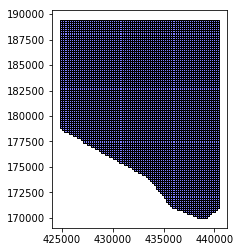

In [17]:
grid_size=200
grids = get_grids(cityline.geometry[0], grid_size)
print(grids.shape)
grids.plot(color='blue')

In [30]:
while grids.crs is None:
    grids.crs= cityline.crs

# crime data

In [9]:
crimes_df = pd.read_csv('data/open-baltimore/raw/BPD_Part_1_Victim_Based_Crime_Data.csv')
crimes_df['geometry'] = crimes_df.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)

In [10]:
crimes_4326 = gp.GeoDataFrame(crimes_df[~crimes_df.Longitude.isnull()][['geometry', 'CrimeDate', 'CrimeTime', 'CrimeCode', 'Weapon']])
crimes_4326.crs = {'init': 'epsg:4326'}

In [11]:
crimes = crimes_4326.to_crs(epsg=3559)

In [12]:
# crimes['lon'] = crimes.geometry.apply(lambda x: x.coords[0][0])
# crimes['lat'] = crimes.geometry.apply(lambda x: x.coords[0][1])
crimes['lonlat'] = crimes.geometry.apply(lambda x: x.coords[0])

In [13]:
crimes['CrimeDate'] = pd.to_datetime(crimes['CrimeDate'], format='%m/%d/%Y')

In [14]:
crimes = crimes.reset_index().set_index('CrimeDate').sort_index()

In [15]:
dates = crimes.index.unique()

In [16]:
dates_bw = dates[dates<'2014-01-01']
dates_eval = dates[dates>='2014-01-01']

# KDE

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [19]:
def bandwidth_selection(data, pt_col='lonlat', bw_choice=None, cv=20):
    pts = data[pt_col].tolist()
    if bw_choice is None:
        bw_choice = np.linspace(10, 1000, 30)
    search = GridSearchCV(KernelDensity(), {'bandwidth': bw_choice}, cv=cv)
    search.fit(pts)
    print(search.best_params_)
    return search.best_params_['bandwidth']

In [20]:
bw = bandwidth_selection(crimes.loc[dates_bw[:10]])
print(bw)

{'bandwidth': 283.10344827586209}


In [21]:
def rolling_window(data, pt_col='lonlat', time_window=60, verbose=True):
    """
    data: pd.DataFrame, index is DatetimeIndex, sorted by index.
    """
    dates = data.index.unique()
    if len(dates)<=time_window:
        raise ValueError('len of dates (%d) is less than time_window (%d)' % (len(dates), time_window))
    num_experiment = len(dates)-time_window
    if verbose:
        print('total number of experiment:', num_experiment)
    for i in range(num_experiment):
        test_date = dates[i+time_window]
        train_start_date = test_date - pd.Timedelta(days=time_window)
        train_end_date = test_date - pd.Timedelta(days=1)
        
        train = data.loc[train_start_date:train_end_date]
        test = data.loc[test_date]
#         print(train_start_date, train_end_date, test_date, train.index.nunique())
        yield train, test

In [36]:
def kde_rolling(data, grids, bw, pt_col='lonlat', return_test_dates=True, verbose=True):
    test_dates = []
    for i, (train, test) in enumerate(rolling_window(data, verbose=verbose)):
        test_date_str = test.index.unique()[0].strftime('%Y-%m-%d')
        test_dates.append(test_date_str)
        if verbose:
            print(train.shape, test.shape, test.index.unique()[0].strftime('%Y-%m-%d'))
        # kde
        kde = KernelDensity(bandwidth=bw)
        kde.fit(train[pt_col].tolist())
        pdf = np.exp(kde.score_samples(grids['cxcy'].tolist()))
        grids['density_'+test_date_str] = pdf
        # test in grids
        test_in_grids = gp.sjoin(test, grids)
        grids =grids.join(test_in_grids.groupby('index_right').agg({'index':'count'}), how='left')\
                        .rename(columns={'index':'num_crimes_'+test_date_str}).fillna(0)
            
        if (i+1) % 20==0:
            print(i, 'round')
    if return_test_dates:
        return grids, test_dates
    return grids

In [37]:
grids_with_result, test_dates = kde_rolling(crimes.loc[dates_eval], grids.copy(), bw, return_test_dates=True, verbose=False)

0 round
1 round
2 round
3 round
4 round
5 round
6 round
7 round
8 round
9 round
10 round
11 round
12 round
13 round


ValueError: cannot reindex from a duplicate axis

In [41]:
grids

,geometry,cxcy,density_2014-03-02,num_crimes_2014-03-02,density_2014-03-03,num_crimes_2014-03-03,density_2014-03-04,num_crimes_2014-03-04,density_2014-03-05,num_crimes_2014-03-05,...,num_crimes_2014-03-11,density_2014-03-12,num_crimes_2014-03-12,density_2014-03-13,num_crimes_2014-03-13,density_2014-03-14,num_crimes_2014-03-14,density_2014-03-15,num_crimes_2014-03-15,density_2014-03-16
0,"POLYGON ((438477.7622064584 169997.5488773746,...","(438377.76220645837, 170097.54887737456)",4.767322e-11,0.0,4.807463e-11,0.0,5.198233e-11,0.0,5.174260e-11,0.0,...,0.0,4.869336e-11,0.0,4.876141e-11,0.0,4.873871e-11,0.0,4.853532e-11,0.0,2.089153e-10
1,"POLYGON ((438677.7622064584 169997.5488773746,...","(438577.76220645837, 170097.54887737456)",2.023465e-11,0.0,2.040503e-11,0.0,2.120233e-11,0.0,2.110455e-11,0.0,...,0.0,2.066764e-11,0.0,2.069653e-11,0.0,2.068689e-11,0.0,2.060056e-11,0.0,1.471706e-10
2,"POLYGON ((438877.7622064584 169997.5488773746,...","(438777.76220645837, 170097.54887737456)",5.350865e-12,0.0,5.395920e-12,0.0,5.509892e-12,0.0,5.484481e-12,0.0,...,0.0,5.465367e-12,0.0,5.473004e-12,0.0,5.470456e-12,0.0,5.447627e-12,0.0,6.415452e-11
3,"POLYGON ((439077.7622064584 169997.5488773746,...","(438977.76220645837, 170097.54887737456)",8.683694e-13,0.0,8.756811e-13,0.0,8.877325e-13,0.0,8.836384e-13,0.0,...,0.0,8.869513e-13,0.0,8.881908e-13,0.0,8.877773e-13,0.0,8.840725e-13,0.0,1.705940e-11
4,"POLYGON ((439277.7622064584 169997.5488773746,...","(439177.76220645837, 170097.54887737456)",8.593094e-14,0.0,8.665448e-14,0.0,8.758955e-14,0.0,8.718560e-14,0.0,...,0.0,8.776975e-14,0.0,8.789241e-14,0.0,8.785148e-14,0.0,8.748487e-14,0.0,2.757179e-12
5,"POLYGON ((438077.7622064584 170197.5488773746,...","(437977.76220645837, 170297.54887737456)",2.247297e-10,0.0,2.266219e-10,0.0,3.160433e-10,0.0,3.145858e-10,0.0,...,0.0,2.295386e-10,0.0,2.298594e-10,0.0,2.297524e-10,0.0,2.287936e-10,0.0,3.025644e-10
6,"POLYGON ((438277.7622064584 170197.5488773746,...","(438177.76220645837, 170297.54887737456)",2.083657e-10,0.0,2.101202e-10,0.0,2.540191e-10,0.0,2.528476e-10,0.0,...,0.0,2.128245e-10,0.0,2.131219e-10,0.0,2.130227e-10,0.0,2.121337e-10,0.0,3.348020e-10
7,"POLYGON ((438477.7622064584 170197.5488773746,...","(438377.76220645837, 170297.54887737456)",1.341129e-10,0.0,1.352421e-10,0.0,1.487106e-10,0.0,1.480248e-10,0.0,...,0.0,1.369827e-10,0.0,1.371742e-10,0.0,1.371103e-10,0.0,1.365381e-10,151.0,3.230617e-10
8,"POLYGON ((438677.7622064584 170197.5488773746,...","(438577.76220645837, 170297.54887737456)",5.627546e-11,0.0,5.674930e-11,0.0,5.942531e-11,0.0,5.915125e-11,0.0,...,0.0,5.747968e-11,0.0,5.756001e-11,0.0,5.753321e-11,0.0,5.729312e-11,0.0,2.200758e-10
9,"POLYGON ((438877.7622064584 170197.5488773746,...","(438777.76220645837, 170297.54887737456)",1.480864e-11,0.0,1.493333e-11,0.0,1.529901e-11,0.0,1.522845e-11,0.0,...,0.0,1.512553e-11,0.0,1.514666e-11,0.0,1.513961e-11,0.0,1.507643e-11,0.0,9.510681e-11


In [47]:
test

,index,geometry,CrimeTime,CrimeCode,Weapon,lonlat
CrimeDate,,,,,,
2014-03-16,192300,POINT (435258.345703607 181225.0880025708),14:45:00,6D,NaN,"(435258.34570360696, 181225.08800257085)"
2014-03-16,192295,POINT (429733.8626839946 180874.7824189413),16:00:00,6E,NaN,"(429733.86268399464, 180874.78241894132)"
2014-03-16,192296,POINT (432941.9113180171 182752.6813963046),15:33:00,6C,NaN,"(432941.91131801705, 182752.6813963046)"
2014-03-16,192293,POINT (433271.8324774211 181416.2791583875),16:00:00,4E,HANDS,"(433271.8324774211, 181416.2791583875)"
2014-03-16,192297,POINT (440408.0354040902 187450.3555019143),15:30:00,6D,NaN,"(440408.0354040902, 187450.35550191434)"
2014-03-16,192298,POINT (425658.3817971542 180733.8868599835),15:00:00,6E,NaN,"(425658.3817971542, 180733.88685998347)"
2014-03-16,192299,POINT (438470.9449068187 188226.6815524828),14:46:00,4C,OTHER,"(438470.9449068187, 188226.6815524828)"
2014-03-16,192294,POINT (427995.4397216506 186754.6977860031),16:00:00,5E,NaN,"(427995.4397216506, 186754.69778600312)"
2014-03-16,192301,POINT (431781.9663559325 177188.0734751573),14:30:00,3B,NaN,"(431781.96635593247, 177188.0734751573)"


In [46]:
grids.index.nunique()

5991

In [49]:
test_in_grids.index.unique()

DatetimeIndex(['2014-03-15'], dtype='datetime64[ns]', freq=None)

In [42]:
test_in_grids = gp.sjoin(test, grids)

ValueError: cannot reindex from a duplicate axis

In [39]:
data = crimes.loc[dates_eval]
grids= grids.copy()
bw=bw
return_test_dates=True
verbose=False
pt_col='lonlat'
test_dates = []
for i, (train, test) in enumerate(rolling_window(data, verbose=verbose)):
    test_date_str = test.index.unique()[0].strftime('%Y-%m-%d')
    test_dates.append(test_date_str)
    if verbose:
        print(train.shape, test.shape, test.index.unique()[0].strftime('%Y-%m-%d'))
    # kde
    kde = KernelDensity(bandwidth=bw)
    kde.fit(train[pt_col].tolist())
    pdf = np.exp(kde.score_samples(grids['cxcy'].tolist()))
    grids['density_'+test_date_str] = pdf
    # test in grids
    test_in_grids = gp.sjoin(test, grids)
    grids =grids.join(test_in_grids.groupby('index_right').agg({'index':'count'}), how='left')\
                    .rename(columns={'index':'num_crimes_'+test_date_str}).fillna(0)

    if (i+1) % 20==0:
        print(i, 'round')

ValueError: cannot reindex from a duplicate axis

# evaluation

In [51]:
grids_with_result = grids

In [53]:
test_dates = test_dates[:-1]

In [57]:
num_grids = len(grids)
idx_for_auc = [int(num_grids * (i+1) / 10) for i in range(9)] + [num_grids-1]

In [58]:
idx_for_auc

[599, 1198, 1797, 2396, 2995, 3594, 4193, 4792, 5391, 5990]

In [59]:
aucs = []
for test_date_str in test_dates:
    grids_with_result.sort_values('density_'+test_date_str, ascending=False, inplace=True)
    hit_rate = grids_with_result['num_crimes_'+test_date_str].cumsum()/grids_with_result['num_crimes_'+test_date_str].sum()
    auc = hit_rate.iloc[idx_for_auc]
    auc.index = ['%d0%%' % (i+1) for i in range(10)]
    aucs.append(auc)
#     break

In [60]:
merge_aucs = pd.concat(aucs,axis=1)

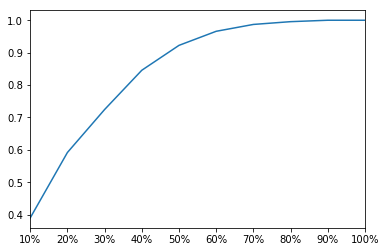

In [61]:
merge_aucs.mean(axis=1).plot()

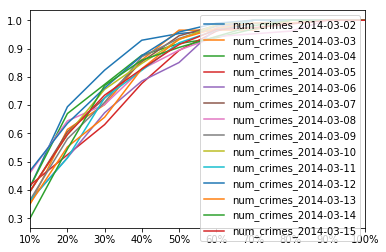

In [62]:
merge_aucs.plot()